In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical

Using TensorFlow backend.


## Import Data

In [2]:
valid_data = pd.read_csv('valid_data')
valid_data.head(5)

,fname,label,manually_verified,Duration
0,00044347.wav,Hi-hat,0,14.00
1,001ca53d.wav,Saxophone,1,10.32
2,0033e230.wav,Glockenspiel,1,8.00
3,00353774.wav,Cello,1,4.52
4,003b91e8.wav,Cello,0,13.28


# Add file path and numerical values for labels

In [3]:
# Add path name to table
valid_data['path'] = 'audio_train/' + valid_data['fname']

# Select verified audio
#valid_data = valid_data.loc[valid_data['manually_verified'] == 1]

# Add numerical values for each label
valid_data['value'] = pd.factorize(valid_data.label)[0]

valid_data.head(10)

,fname,label,manually_verified,Duration,path,value
0,00044347.wav,Hi-hat,0,14.00,audio_train/00044347.wav,0
1,001ca53d.wav,Saxophone,1,10.32,audio_train/001ca53d.wav,1
2,0033e230.wav,Glockenspiel,1,8.00,audio_train/0033e230.wav,2
3,00353774.wav,Cello,1,4.52,audio_train/00353774.wav,3
4,003b91e8.wav,Cello,0,13.28,audio_train/003b91e8.wav,3
5,004ad66f.wav,Clarinet,0,7.00,audio_train/004ad66f.wav,4
6,0063ab88.wav,Computer_keyboard,0,29.64,audio_train/0063ab88.wav,5
7,0075d39c.wav,Keys_jangling,0,20.64,audio_train/0075d39c.wav,6
8,0079d310.wav,Writing,0,4.06,audio_train/0079d310.wav,7
9,0091fc7f.wav,Cello,1,5.70,audio_train/0091fc7f.wav,3


In [4]:
print(valid_data.shape)
print(valid_data['label'].nunique())

(5580, 6)
41


# Plot duration of files

In [5]:
valid_data['Duration'].hist(bins = 27)

# Spectrogram Examples

In [6]:
# Example of a Hi Hat spectrogram
y, sr = librosa.load('audio_train/00044347.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

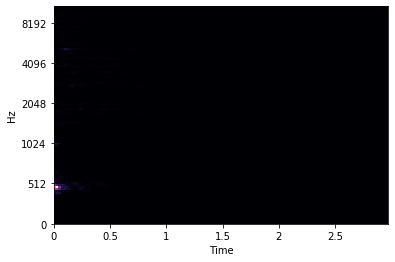

In [7]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [8]:
# Example of a Saxophone spectrogram
y, sr = librosa.load('audio_train/001ca53d.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

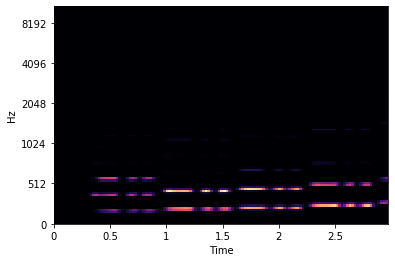

In [9]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

# Create Spectrograms For All Data
## Path different on different comps

In [10]:
D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load(row.path, duration= 2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    D.append( (ps, row.value) )

In [11]:
print("Number of samples: ", len(D))

Number of samples:  5580


# Split Dataset into Test / Train

In [12]:
dataset = D
random.shuffle(dataset)

In [13]:
data = pd.DataFrame(dataset, columns = ['mel-spec', 'label'])
data.head(5)

,mel-spec,label
0,"[[19.043505, 7.317459, 0.35966074, 0.29379424,...",30
1,"[[5.158734e-06, 2.9669454e-06, 2.844914e-06, 6...",15
2,"[[1.1881718e-05, 6.3776047e-06, 9.024962e-06, ...",19
3,"[[0.8079539, 0.7193784, 0.62395996, 1.4713075,...",3
4,"[[5.119874e-06, 4.2211827e-06, 4.321815e-06, 3...",3


In [14]:
x = data['mel-spec'].values
y = to_categorical(data['label'].values)

In [15]:
#Stratify and split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

#Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

In [16]:
#train = dataset[:4464]
#test = dataset[4464:]

#X_train, y_train = zip(*train)
#X_test, y_test = zip(*test)

# Reshape for CNN input
#X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
#X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
#y_train = np.array(keras.utils.to_categorical(y_train, 41))
#y_test = np.array(keras.utils.to_categorical(y_test, 41))

# Convolutional Neural Network

In [17]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(32, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

#model.add(Dense(10))
model.add(Dense(41))
model.add(Activation('softmax'))

In [18]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model.fit(
    x=X_train, 
    y=y_train,
    epochs=80,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 4464 samples, validate on 1116 samples
Epoch 1/80
4464/4464 [==============================] - 49s 11ms/step - loss: 5.4709 - accuracy: 0.0511 - val_loss: 3.7154 - val_accuracy: 0.0726
Epoch 2/80
4464/4464 [==============================] - 49s 11ms/step - loss: 3.6998 - accuracy: 0.0609 - val_loss: 3.6891 - val_accuracy: 0.0591
Epoch 3/80
4464/4464 [==============================] - 53s 12ms/step - loss: 3.6613 - accuracy: 0.0699 - val_loss: 3.6574 - val_accuracy: 0.0690
Epoch 4/80
4464/4464 [==============================] - 51s 12ms/step - loss: 3.6182 - accuracy: 0.0748 - val_loss: 3.6145 - val_accuracy: 0.0950
Epoch 5/80
4464/4464 [==============================] - 51s 11ms/step - loss: 3.5677 - accuracy: 0.0876 - val_loss: 3.5595 - val_accuracy: 0.1219
Epoch 6/80
4464/4464 [==============================] - 51s 12ms/step - loss: 3.4690 - accuracy: 0.1136 - val_loss: 3.4955 - val_accuracy: 0.1407
Epoch 7/80
4464/4464 [==============================] - 49s 11ms/step - loss

4464/4464 [==============================] - 51s 11ms/step - loss: 1.5812 - accuracy: 0.5419 - val_loss: 2.9458 - val_accuracy: 0.4113
Epoch 57/80
4464/4464 [==============================] - 52s 12ms/step - loss: 1.6148 - accuracy: 0.5417 - val_loss: 2.8294 - val_accuracy: 0.4274
Epoch 58/80
4464/4464 [==============================] - 55s 12ms/step - loss: 1.5976 - accuracy: 0.5475 - val_loss: 2.6779 - val_accuracy: 0.4050
Epoch 59/80
4464/4464 [==============================] - 55s 12ms/step - loss: 1.5953 - accuracy: 0.5401 - val_loss: 2.8515 - val_accuracy: 0.4185
Epoch 60/80
4464/4464 [==============================] - 54s 12ms/step - loss: 1.6711 - accuracy: 0.5383 - val_loss: 2.8472 - val_accuracy: 0.4185
Epoch 61/80
4464/4464 [==============================] - 46s 10ms/step - loss: 1.6272 - accuracy: 0.5475 - val_loss: 2.8103 - val_accuracy: 0.4328
Epoch 62/80
4464/4464 [==============================] - 43s 10ms/step - loss: 1.6111 - accuracy: 0.5423 - val_loss: 2.7788 - val_


# Confusion Matrix

In [19]:
# Get predictions
y_pred = model.predict_classes(X_test)
conf_test = y_test.argmax(axis=1)

# Dataframe
comp = pd.DataFrame({'y_pred': y_pred, 'y_test': conf_test})

# Matrix
matrix = confusion_matrix(conf_test, y_pred)
matrix

array([[14,  0,  0, ...,  0,  0,  0],
       [ 0, 26,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  6,  0,  0],
       [ 1,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  4]])

In [24]:
#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(30, 30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.jpg')
    plt.show()

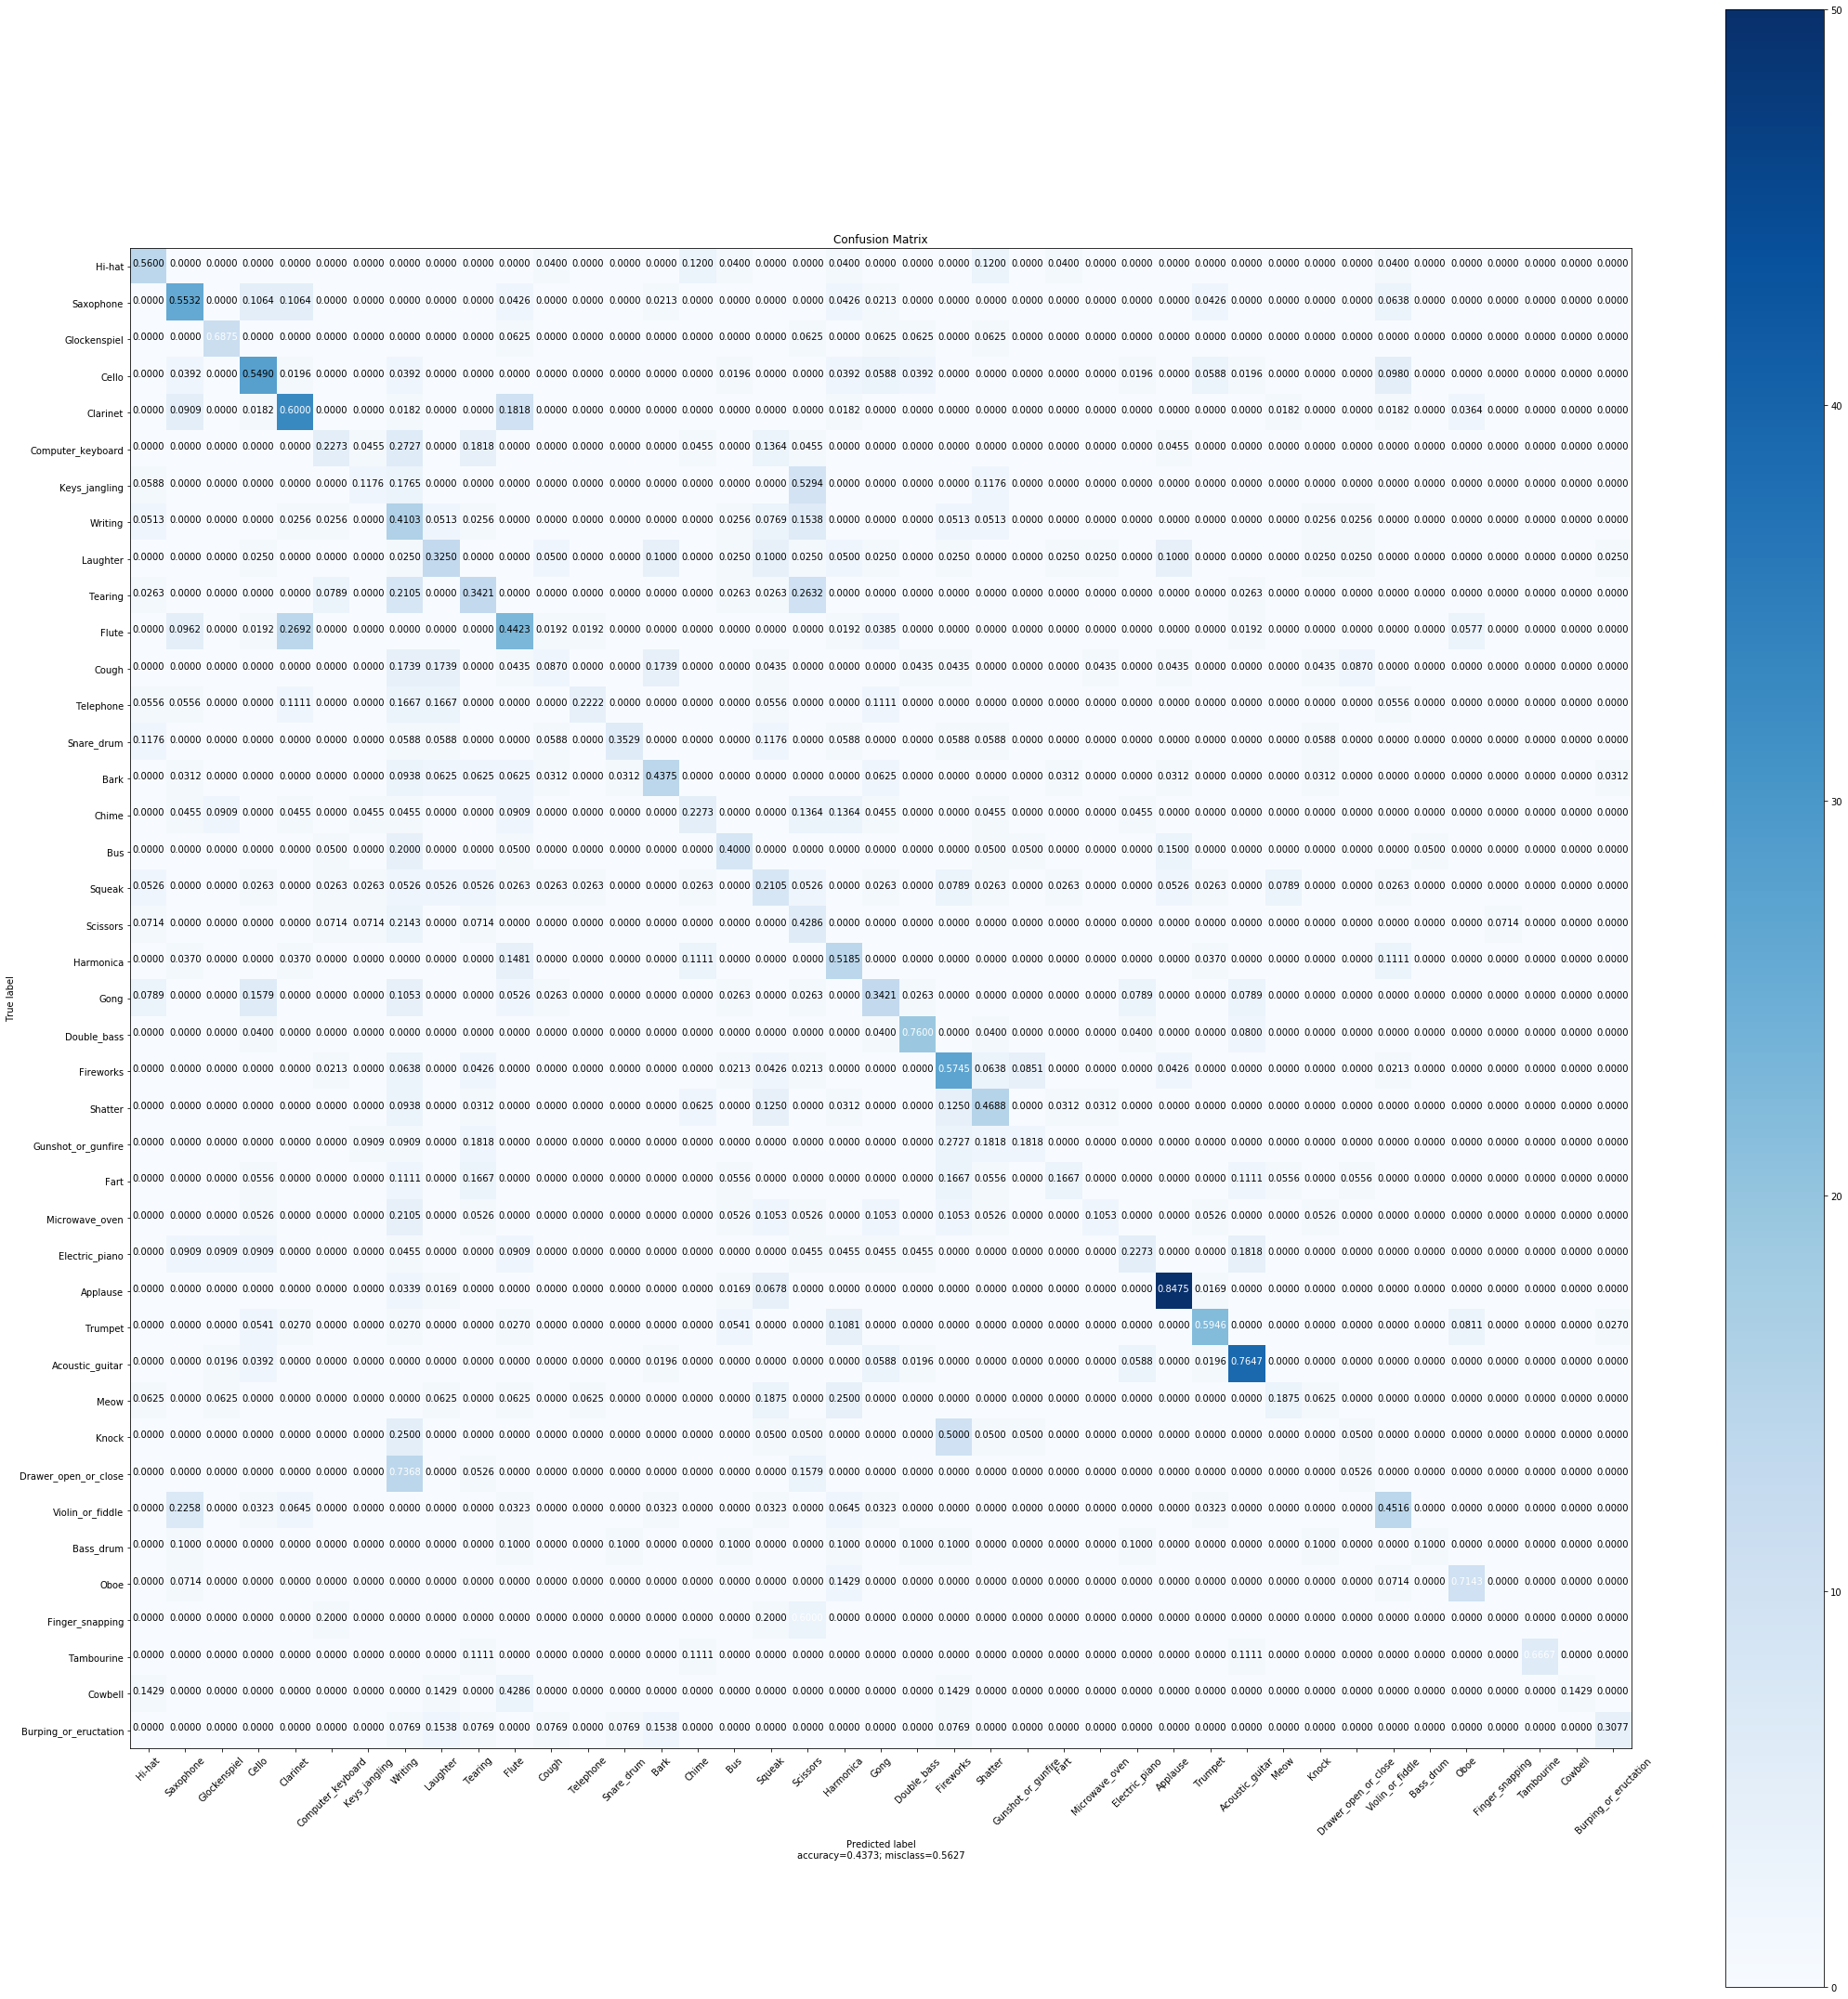

In [25]:
plot_confusion_matrix(matrix, normalize    = True,
                      target_names = valid_data.label.unique(),
                      title        = "Confusion Matrix")